In [1]:
import torch
import numpy as np
from torch import nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T
from torch import optim
import random

torch.manual_seed(1)
np.random.seed(1)
random.seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.benchmark = True
torch.use_deterministic_algorithms(False)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_properties(device)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)

In [ ]:
# transform 1

# transforms_train = T.Compose([
# 	T.RandomCrop(32, padding=4),
# 	T.RandomHorizontalFlip(),
# 	T.ToTensor(),
# 	T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# transforms_test = T.Compose([
# 	T.ToTensor(),
# 	T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

In [11]:
# transform 2

transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transforms_test = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ])

Files already downloaded and verified
Files already downloaded and verified


torch.Size([3, 32, 32])
2 bird


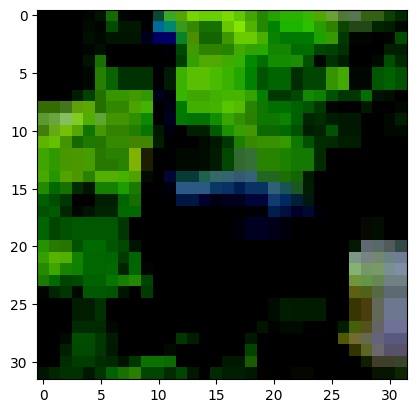

In [12]:
# Загружаем данные для обучения и валидации, применяя один из "transform"

train_dataset = torchvision.datasets.CIFAR10(root='../', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='../', train=False, download=True, transform=transforms_test)

# Список классов для лэйблов
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




image, label = train_dataset[6]
print(image.size())
print(label, classes[label])

plt.imshow(image.permute(1, 2, 0).numpy());

In [13]:
# Загружаем данные при помощи "DataLoader" на cuda для более быстрых вычислений
# Изменил batch_size

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100,
                                           shuffle=True,
                                           pin_memory_device="cuda:0")

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10,
                                          shuffle=False,
                                          pin_memory_device="cuda:0")



In [14]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:597: UserWarning: pin memory device is set and pin_memory flag is not used then device pinned memory won't be usedplease set pin_memory to true, if you need to use the device pin memory
  warnings.warn(warn_msg)


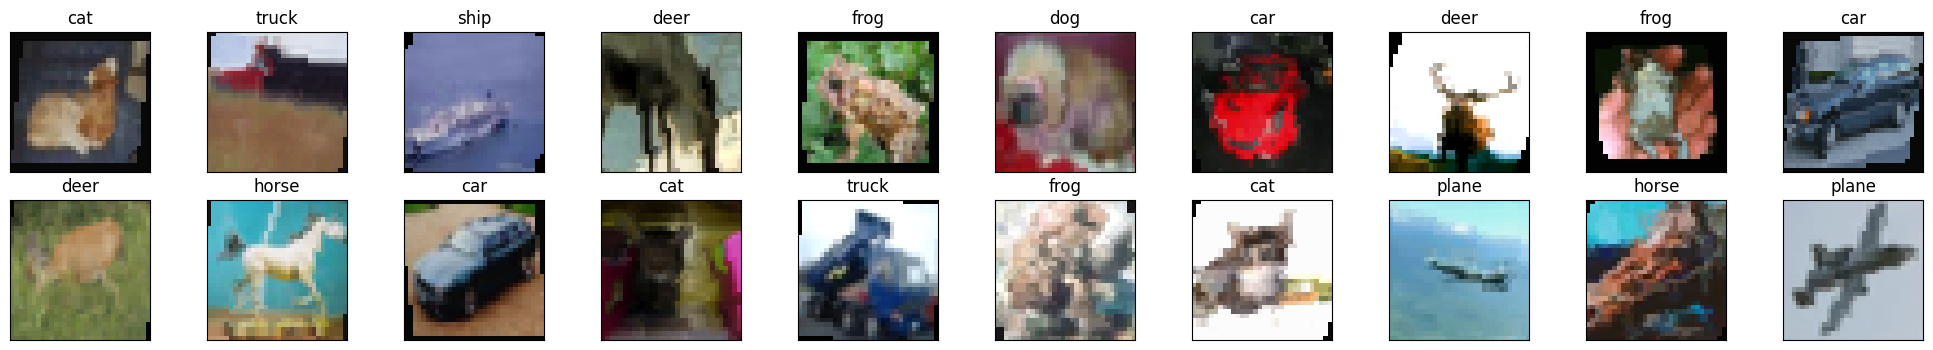

In [15]:
# Посмотрим полученные данные
dataiter = iter(train_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [17]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 6 * hidden_dim)
        self.fc2 = nn.Linear(6 * hidden_dim, 4 * hidden_dim)
        self.fc_added = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1) # reshape [3, 32, 32] = [3072]
        x = self.fc1(x)            # внутренний полносвязный линейный слой
        x = F.leaky_relu(x)        # функция активации
        x = self.fc2(x)
        x = F.leaky_relu(x)

        x = self.fc_added(x)
        x = F.leaky_relu(x)

        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        return x                   # Выход последнего слоя -> подсчет ошибки

    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)

        x = self.fc_added(x)
        x = F.leaky_relu(x)

        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        x = F.softmax(x)           # Предсказание - вероятность класса
        return x


net = Net(3072, 50, 10).to(device) # Запись на cuda
net.train()

Net(
  (fc1): Linear(in_features=3072, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc_added): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=10, bias=True)
)

In [18]:
criterion = nn.CrossEntropyLoss()   #  много-классовая перекрестная кросс-энтропия

# На выбор 2 оптимизатора показавших лучшее значения на лосс
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [19]:
# Увеличел количество эпох в обучении
num_epochs = 10

for epoch in range(num_epochs):
    running_loss, running_items = 0.0, 0.0


    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

         # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs.to(device))
        # Рассчитываем лосс-функцию
        loss = criterion(outputs.to(device), labels.to(device))
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.5f}')
            running_loss, running_items = 0.0, 0.0

print('Training is finished!')

Epoch [1/10]. Step [1/500]. Loss: 0.02322
Epoch [1/10]. Step [301/500]. Loss: 0.01870
Epoch [2/10]. Step [1/500]. Loss: 0.01555
Epoch [2/10]. Step [301/500]. Loss: 0.01639
Epoch [3/10]. Step [1/500]. Loss: 0.01630
Epoch [3/10]. Step [301/500]. Loss: 0.01553
Epoch [4/10]. Step [1/500]. Loss: 0.01470
Epoch [4/10]. Step [301/500]. Loss: 0.01489
Epoch [5/10]. Step [1/500]. Loss: 0.01361
Epoch [5/10]. Step [301/500]. Loss: 0.01457
Epoch [6/10]. Step [1/500]. Loss: 0.01419
Epoch [6/10]. Step [301/500]. Loss: 0.01418
Epoch [7/10]. Step [1/500]. Loss: 0.01405
Epoch [7/10]. Step [301/500]. Loss: 0.01387
Epoch [8/10]. Step [1/500]. Loss: 0.01416
Epoch [8/10]. Step [301/500]. Loss: 0.01362
Epoch [9/10]. Step [1/500]. Loss: 0.01319
Epoch [9/10]. Step [301/500]. Loss: 0.01349
Epoch [10/10]. Step [1/500]. Loss: 0.01165
Epoch [10/10]. Step [301/500]. Loss: 0.01319
Training is finished!


In [20]:
data_iter = iter(test_loader)

In [68]:
images, labels = next(data_iter)

GroundTruth:  ship car car horse bird dog bird horse ship truck


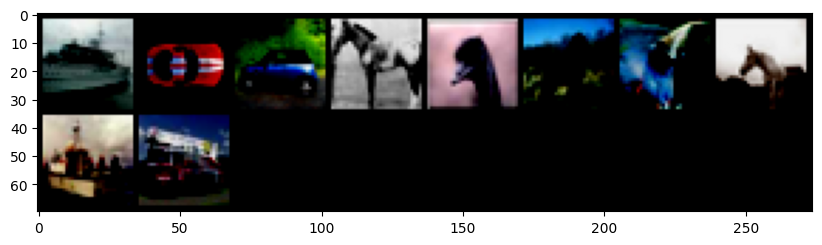

In [69]:
net.eval()
outputs = net(images.to(device))
imgs = torchvision.utils.make_grid(images)
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))

In [70]:
_, predicted = torch.max(outputs, 1)

In [71]:
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['ship' 'car' 'car' 'horse' 'bird' 'dog' 'bird' 'horse' 'ship' 'truck']
['ship' 'car' 'car' 'cat' 'bird' 'horse' 'bird' 'ship' 'ship' 'truck']
Accuracy is 0.7
